<a href="https://colab.research.google.com/github/JaminUbuntu/IBOK_viz/blob/main/PySpark_Code_Benjamin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySpark Analysis on House Price

# Importing Libraries and Loading files

In [1]:
!pip install pyspark

In [2]:
!pip install findspark

In [3]:
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.11/dist-packages/pyspark'

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HousePricePred").getOrCreate()

In [107]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load Data
df = spark.read.csv("/content/all_perth_310121.csv", header=True, inferSchema=True, multiLine=True, escape="\"")
df.show()

+--------------------+------------+------+--------+---------+------+---------+----------+----------+--------+--------------------+----------------+---------+--------+------------+-----------+--------------------+-------------------+----------------+
|             ADDRESS|      SUBURB| PRICE|BEDROOMS|BATHROOMS|GARAGE|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|         NEAREST_STN|NEAREST_STN_DIST|DATE_SOLD|POSTCODE|    LATITUDE|  LONGITUDE|         NEAREST_SCH|   NEAREST_SCH_DIST|NEAREST_SCH_RANK|
+--------------------+------------+------+--------+---------+------+---------+----------+----------+--------+--------------------+----------------+---------+--------+------------+-----------+--------------------+-------------------+----------------+
|       1 Acorn Place|  South Lake|565000|       4|        2|     2|      600|       160|      2003|   18300|Cockburn Central ...|            1800|09-2018\r|    6164|    -32.1159|  115.84245|LAKELAND SENIOR H...| 0.8283385518162787|            NULL|


# Data Preprocessing/EDA

In [7]:
df.printSchema()

root
 |-- ADDRESS: string (nullable = true)
 |-- SUBURB: string (nullable = true)
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- GARAGE: string (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: string (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN: string (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: string (nullable = true)
 |-- POSTCODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH: string (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)



In [8]:
df.describe().show()

+-------+----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+-----------------+-------------------+-------------------+--------------------+-------------------+-----------------+
|summary|         ADDRESS|           SUBURB|             PRICE|          BEDROOMS|         BATHROOMS|            GARAGE|         LAND_AREA|        FLOOR_AREA|        BUILD_YEAR|          CBD_DIST|       NEAREST_STN| NEAREST_STN_DIST|DATE_SOLD|         POSTCODE|           LATITUDE|          LONGITUDE|         NEAREST_SCH|   NEAREST_SCH_DIST| NEAREST_SCH_RANK|
+-------+----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+-----------------+-----------------

Checking for NULL values

In [9]:
from pyspark.sql.functions import count, when, col, isnan

df.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    for c in df.columns
]).show()

+-------+------+-----+--------+---------+------+---------+----------+----------+--------+-----------+----------------+---------+--------+--------+---------+-----------+----------------+----------------+
|ADDRESS|SUBURB|PRICE|BEDROOMS|BATHROOMS|GARAGE|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN|NEAREST_STN_DIST|DATE_SOLD|POSTCODE|LATITUDE|LONGITUDE|NEAREST_SCH|NEAREST_SCH_DIST|NEAREST_SCH_RANK|
+-------+------+-----+--------+---------+------+---------+----------+----------+--------+-----------+----------------+---------+--------+--------+---------+-----------+----------------+----------------+
|      0|     0|    0|       0|        0|     0|        0|         0|         0|       0|          0|               0|        0|       0|       0|        0|          0|               0|           10952|
+-------+------+-----+--------+---------+------+---------+----------+----------+--------+-----------+----------------+---------+--------+--------+---------+-----------+----------------+---

Removing NULL Values

In [10]:
df_cleaned = df.dropna()

df_cleaned.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    for c in df_cleaned.columns
]).show()

+-------+------+-----+--------+---------+------+---------+----------+----------+--------+-----------+----------------+---------+--------+--------+---------+-----------+----------------+----------------+
|ADDRESS|SUBURB|PRICE|BEDROOMS|BATHROOMS|GARAGE|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN|NEAREST_STN_DIST|DATE_SOLD|POSTCODE|LATITUDE|LONGITUDE|NEAREST_SCH|NEAREST_SCH_DIST|NEAREST_SCH_RANK|
+-------+------+-----+--------+---------+------+---------+----------+----------+--------+-----------+----------------+---------+--------+--------+---------+-----------+----------------+----------------+
|      0|     0|    0|       0|        0|     0|        0|         0|         0|       0|          0|               0|        0|       0|       0|        0|          0|               0|               0|
+-------+------+-----+--------+---------+------+---------+----------+----------+--------+-----------+----------------+---------+--------+--------+---------+-----------+----------------+---

In [11]:
df_cleaned.show()

+--------------------+---------------+-------+--------+---------+------+---------+----------+----------+--------+--------------------+----------------+---------+--------+------------+-----------+--------------------+------------------+----------------+
|             ADDRESS|         SUBURB|  PRICE|BEDROOMS|BATHROOMS|GARAGE|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|         NEAREST_STN|NEAREST_STN_DIST|DATE_SOLD|POSTCODE|    LATITUDE|  LONGITUDE|         NEAREST_SCH|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|
+--------------------+---------------+-------+--------+---------+------+---------+----------+----------+--------+--------------------+----------------+---------+--------+------------+-----------+--------------------+------------------+----------------+
|         1 Addis Way|          Wandi| 365000|       3|        2|     2|      351|       139|      2013|   26900|     Kwinana Station|            4900|02-2019\r|    6167|-32.19347028|115.8595535|      ATWELL COLLEGE| 5.524324354371822|      

In [12]:
# Select only numeric columns for Visualuzation
numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double', 'float', 'bigint')]

# Assign numeric columns to a new DataFrame
df_numeric = df.select(numeric_columns)

# Show result
df_numeric.columns

['PRICE',
 'BEDROOMS',
 'BATHROOMS',
 'LAND_AREA',
 'FLOOR_AREA',
 'CBD_DIST',
 'NEAREST_STN_DIST',
 'POSTCODE',
 'LATITUDE',
 'LONGITUDE',
 'NEAREST_SCH_DIST',
 'NEAREST_SCH_RANK']

In [13]:
sns.set_style('whitegrid') # For grids on numerical plots

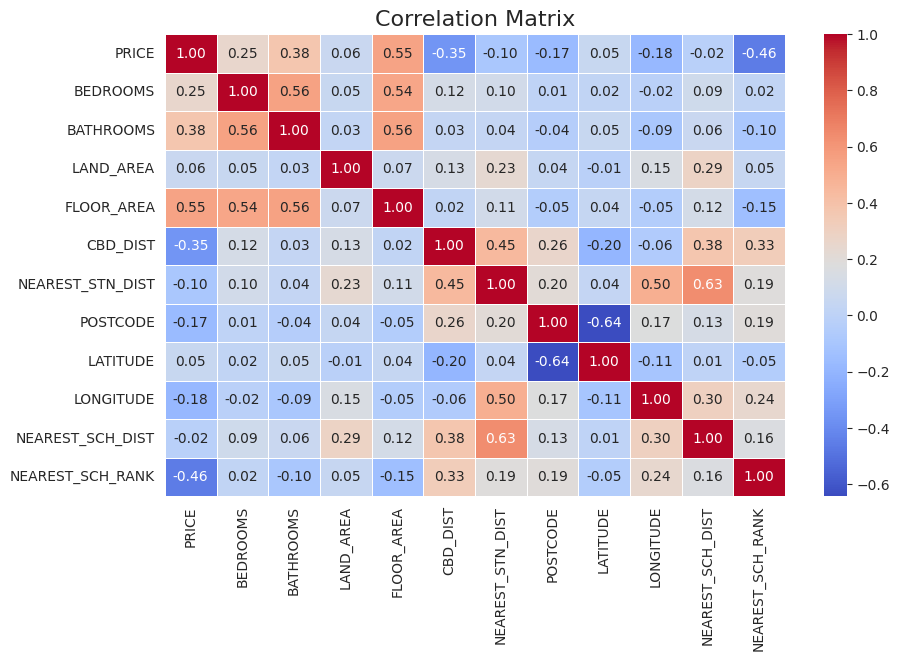

In [15]:
# Convert to Pandas
df_pd = df_numeric.select("*").toPandas()

# Compute correlation matrix
corr_matrix = df_pd.corr()

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

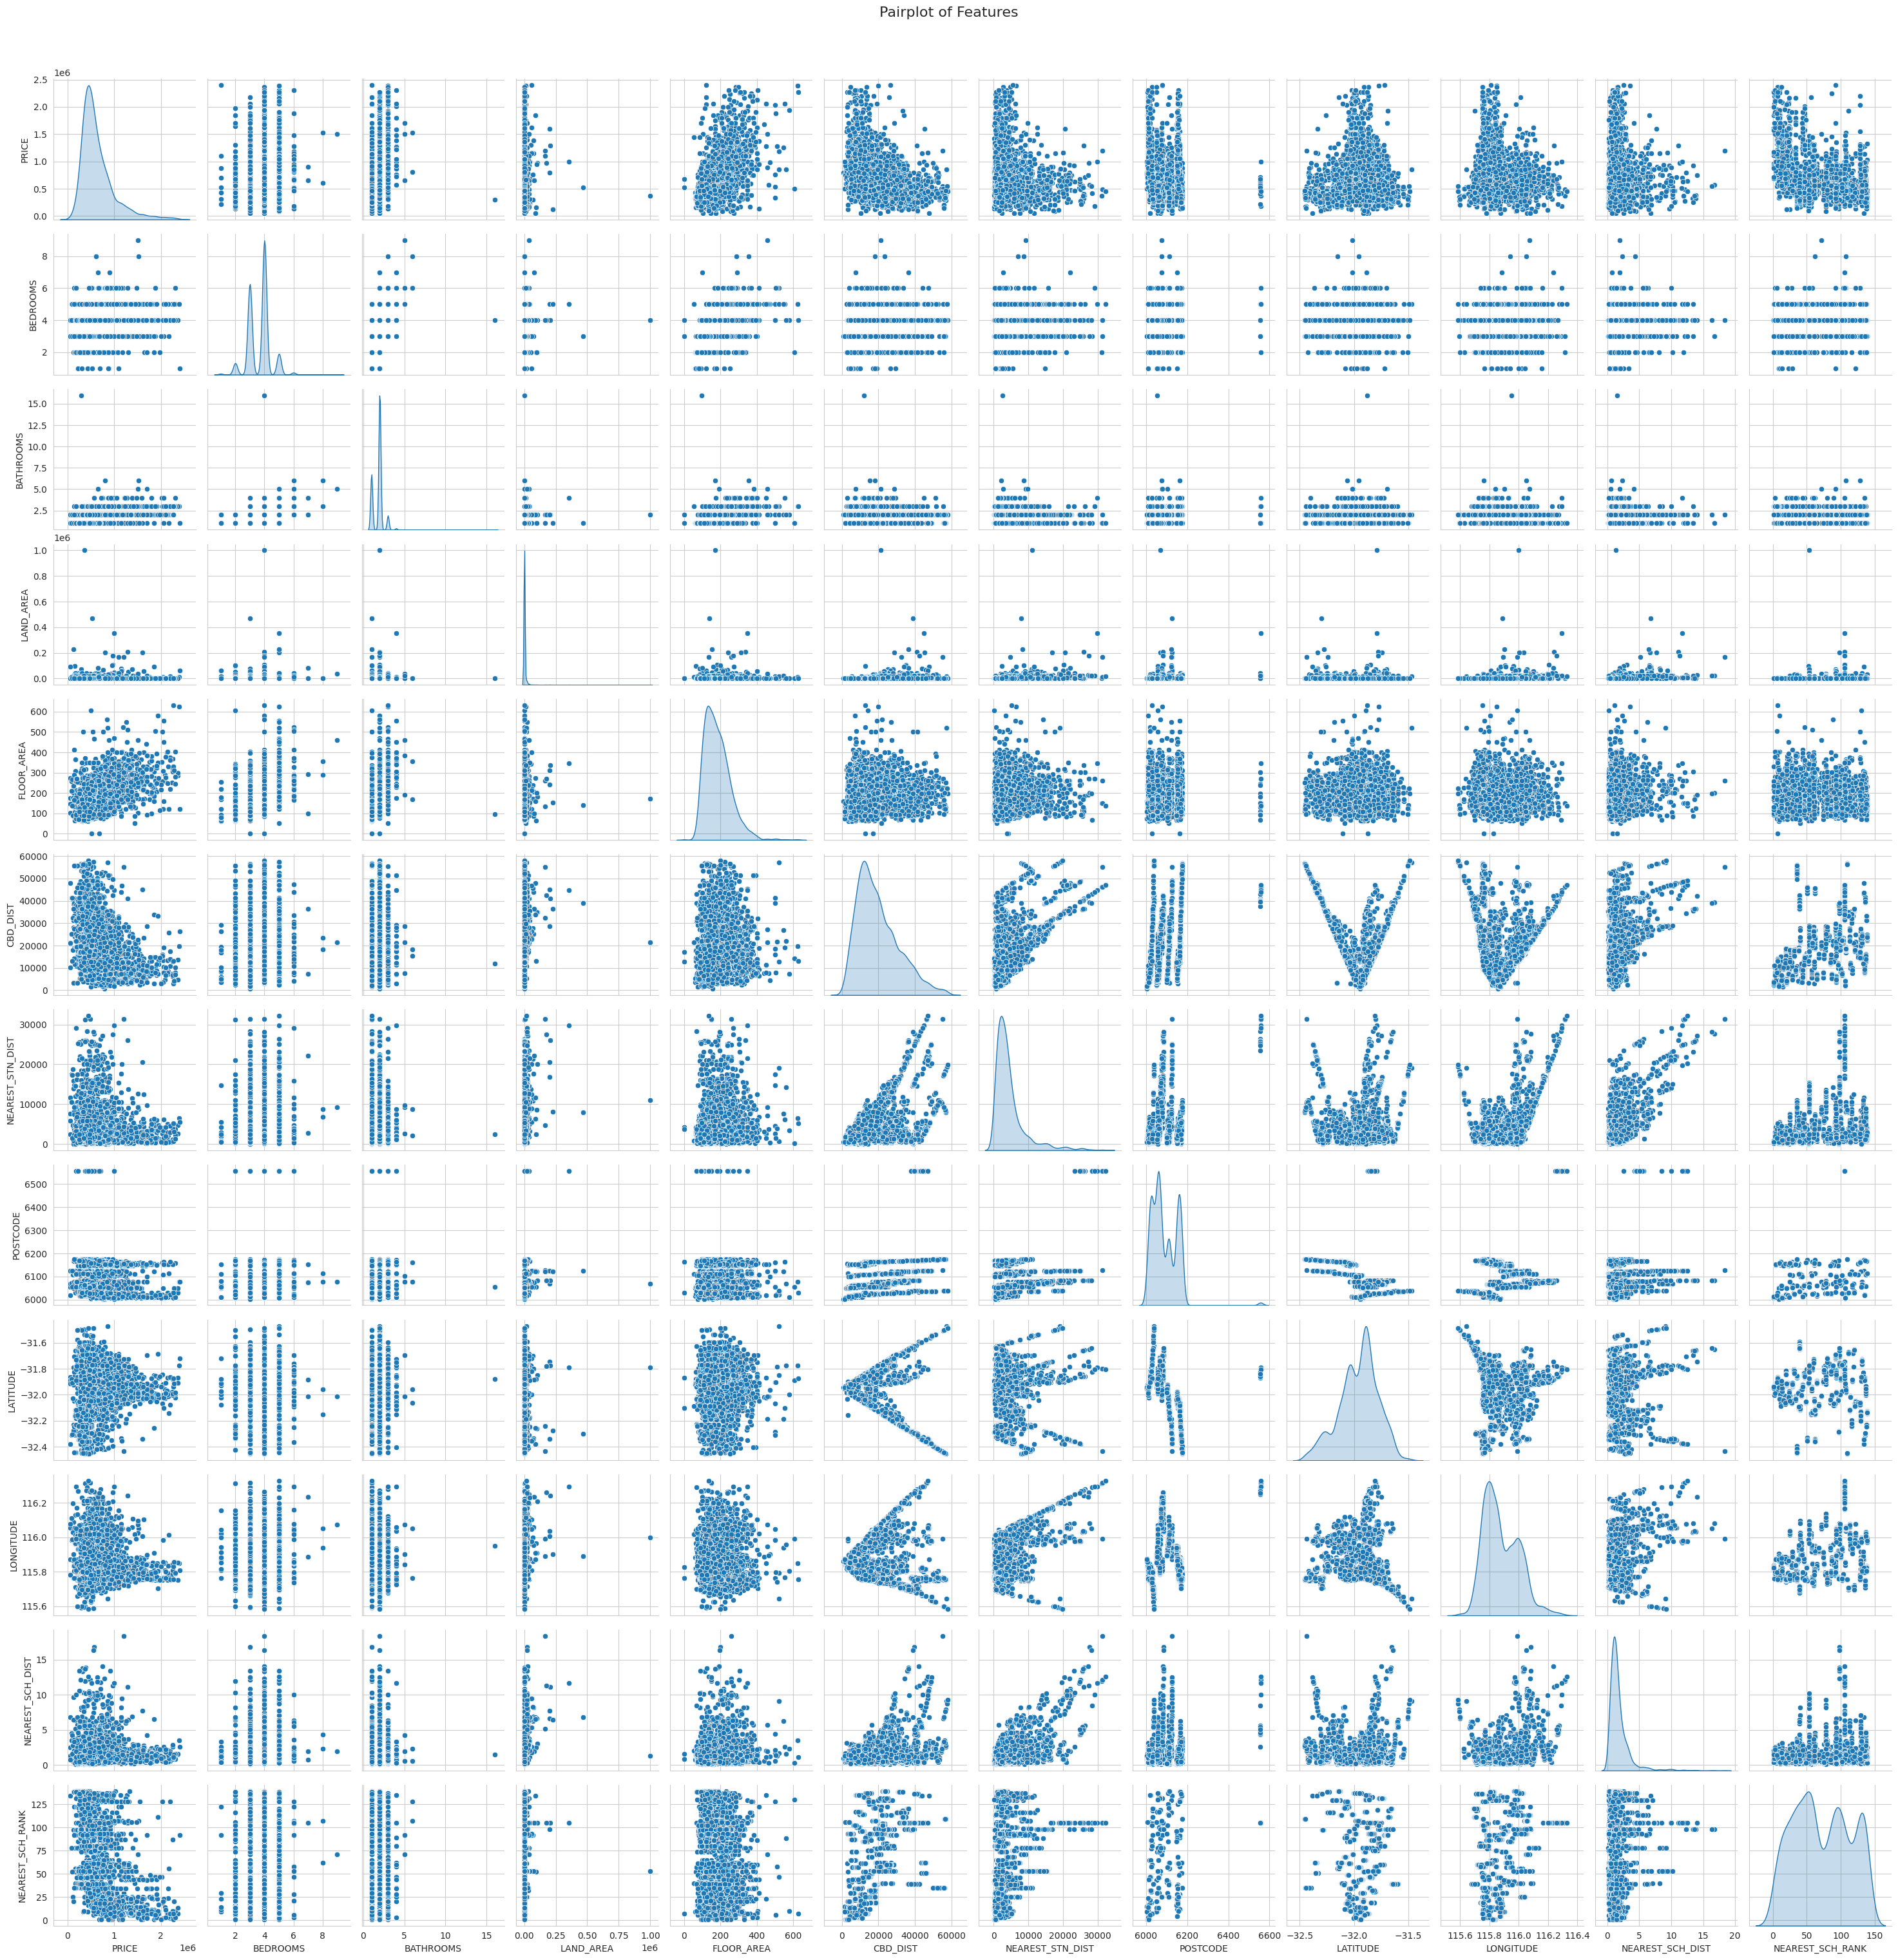

In [16]:
# Sample a subset of data
df_sample = df_pd.sample(frac=0.1, random_state=42)

# Pairplot
sns.pairplot(df_sample, diag_kind="kde")
plt.suptitle("Pairplot of Features", y=1.02, fontsize=16)
plt.show()

View Boxplots

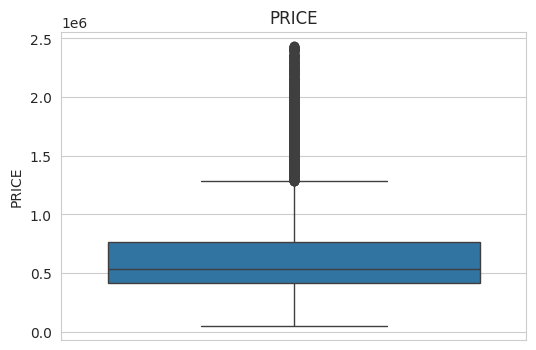

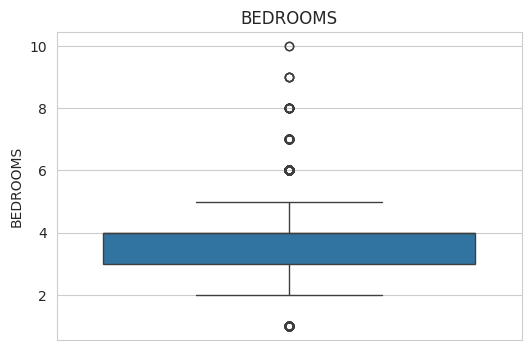

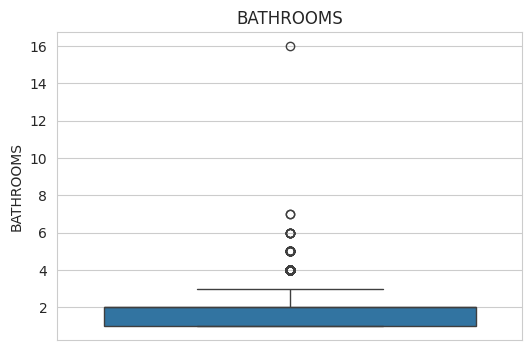

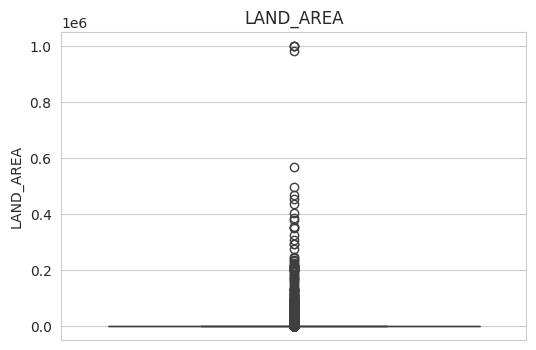

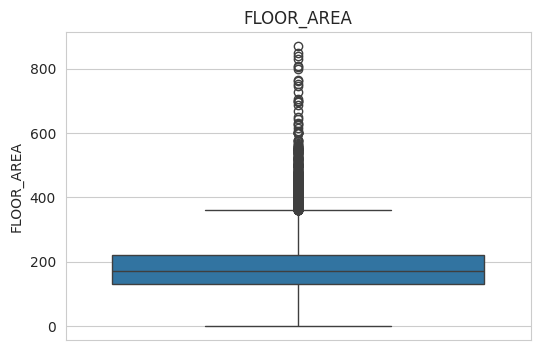

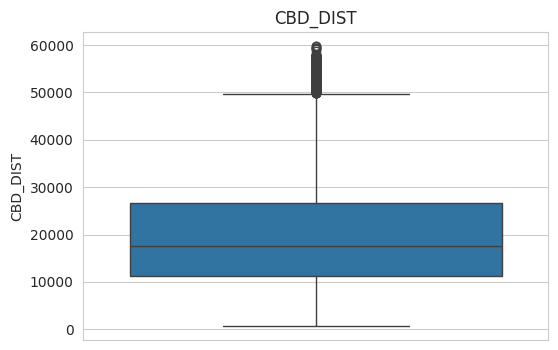

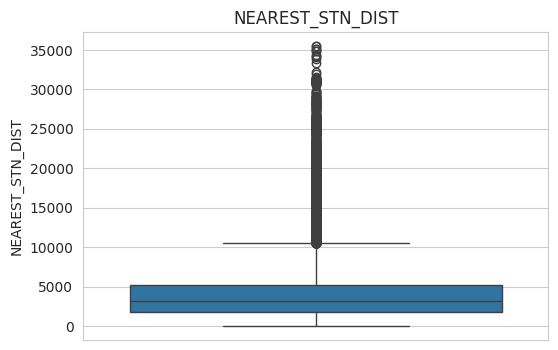

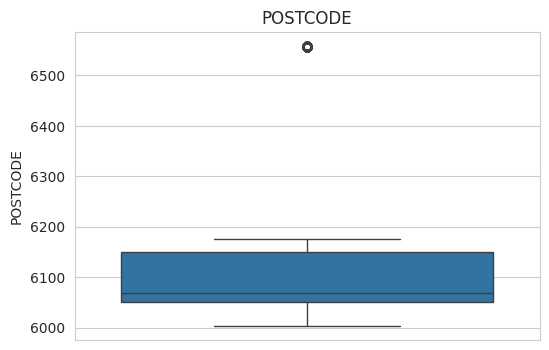

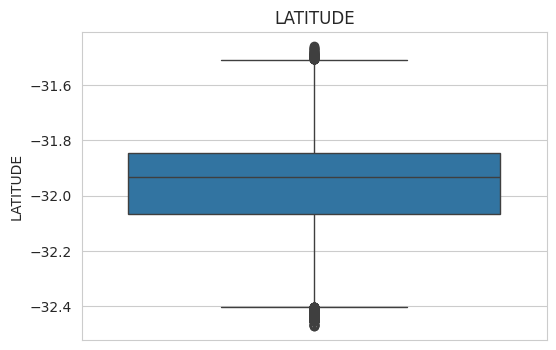

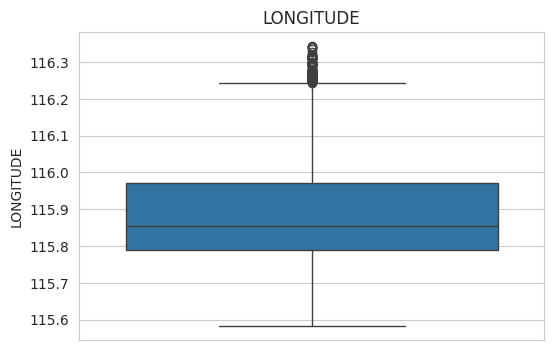

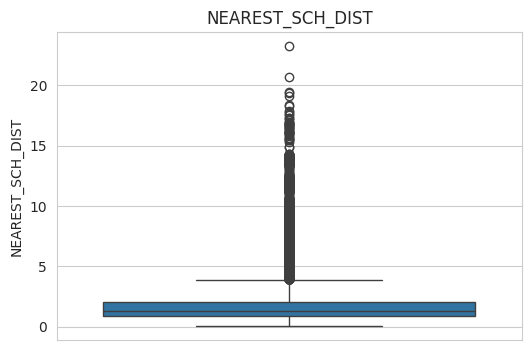

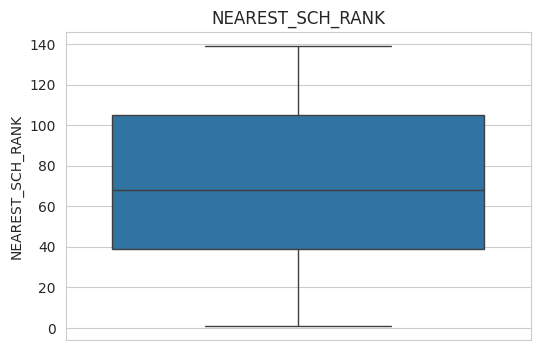

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = [col for col, dtype in df.dtypes if dtype in ('int', 'double')]

# Convert to Pandas for visualization
df_numeric = df.select(numeric_cols).toPandas()

# Plot each numeric column in a separate row
for col in numeric_cols:
    plt.figure(figsize=(6, 4))  # Set individual figure size
    sns.boxplot(y=df_numeric[col])
    plt.title(col)  # Set title for each plot
    plt.xticks([])  # Remove x-axis labels for clarity
    plt.show()  # Show each plot separately

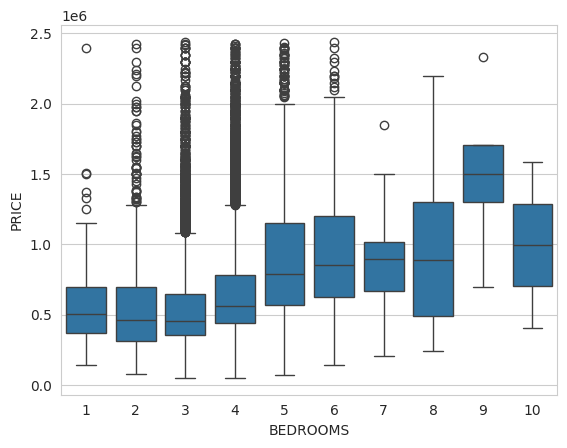

In [18]:
sns.boxplot(x=df_pd['BEDROOMS'],y=df_pd['PRICE'])
plt.show()

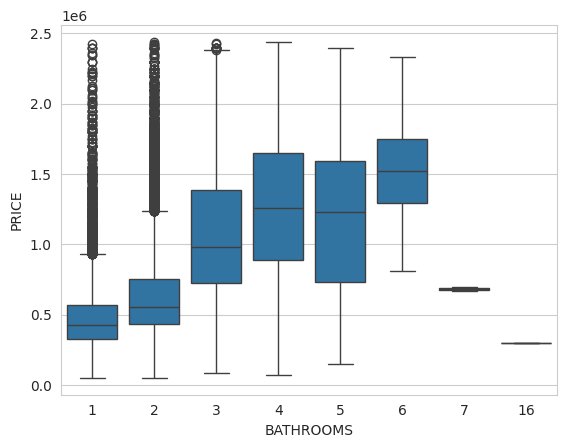

In [19]:
sns.boxplot(x=df_pd['BATHROOMS'],y=df_pd['PRICE'])
plt.show()

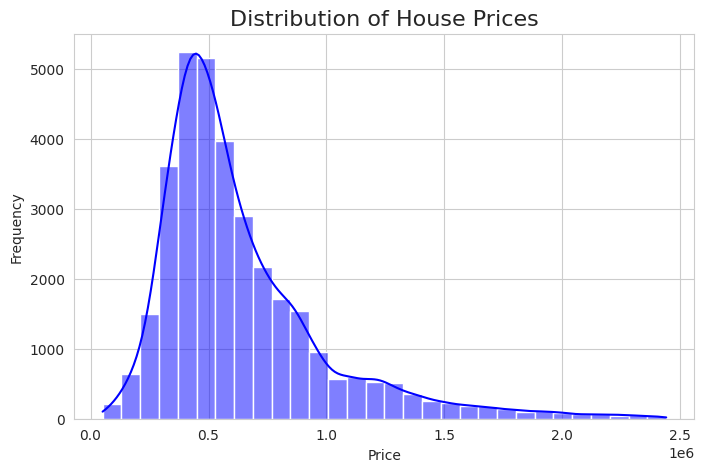

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df_pd["PRICE"], bins=30, kde=True, color="blue")
plt.title("Distribution of House Prices", fontsize=16)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

Dropping unwanted features

In [21]:
df_ready = df_cleaned.drop("ADDRESS", "SUBURB", "NEAREST_STN" ,"GARAGE", "POSTCODE","NEAREST_SCH")
df_ready.show()

+-------+--------+---------+---------+----------+----------+--------+----------------+---------+------------+-----------+------------------+----------------+
|  PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST|DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|
+-------+--------+---------+---------+----------+----------+--------+----------------+---------+------------+-----------+------------------+----------------+
| 365000|       3|        2|      351|       139|      2013|   26900|            4900|02-2019\r|-32.19347028|115.8595535| 5.524324354371822|             129|
| 287000|       3|        1|      719|        86|      1979|   22600|            1900|06-2015\r|-32.12057813| 115.993579| 1.649178183366986|             113|
| 685000|       3|        2|      552|       126|      1999|    5900|             508|10-2019\r|   -31.91788|  115.90705| 0.936243264888652|              29|
| 367500|       3|        2|      398|       158|   

Removing the /r in the date field

In [22]:
from pyspark.sql.functions import regexp_replace

# Remove the \r from the DATE_SOLD column
df_ready = df_ready.withColumn("DATE_SOLD", regexp_replace("DATE_SOLD", "\\r", ""))

# Display the result
df_ready.show()

+-------+--------+---------+---------+----------+----------+--------+----------------+---------+------------+-----------+------------------+----------------+
|  PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST|DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|
+-------+--------+---------+---------+----------+----------+--------+----------------+---------+------------+-----------+------------------+----------------+
| 365000|       3|        2|      351|       139|      2013|   26900|            4900|  02-2019|-32.19347028|115.8595535| 5.524324354371822|             129|
| 287000|       3|        1|      719|        86|      1979|   22600|            1900|  06-2015|-32.12057813| 115.993579| 1.649178183366986|             113|
| 685000|       3|        2|      552|       126|      1999|    5900|             508|  10-2019|   -31.91788|  115.90705| 0.936243264888652|              29|
| 367500|       3|        2|      398|       158|   

Encoding the DATE_SOLD feature

In [37]:
from pyspark.sql.functions import to_date, year, month, dayofmonth, unix_timestamp

# Convert DATE_SOLD to proper date format
df_ready = df_ready.withColumn("DATE_SOLD", to_date("DATE_SOLD", "MM-yyyy"))

# Extract time components
df_ready = df_ready.withColumn("YEAR_SOLD", year("DATE_SOLD")) \
       .withColumn("MONTH_SOLD", month("DATE_SOLD"))

# Create a timestamp
df_t = df_ready.withColumn("DATE_TIMESTAMP", unix_timestamp("DATE_SOLD"))

# Display the result
df_t.select("DATE_SOLD", "YEAR_SOLD", "MONTH_SOLD", "DATE_TIMESTAMP").show()

+----------+---------+----------+--------------+
| DATE_SOLD|YEAR_SOLD|MONTH_SOLD|DATE_TIMESTAMP|
+----------+---------+----------+--------------+
|2019-02-01|     2019|         2|    1548979200|
|2015-06-01|     2015|         6|    1433116800|
|2019-10-01|     2019|        10|    1569888000|
|2018-11-01|     2018|        11|    1541030400|
|2019-07-01|     2019|         7|    1561939200|
|2017-11-01|     2017|        11|    1509494400|
|2017-11-01|     2017|        11|    1509494400|
|2020-10-01|     2020|        10|    1601510400|
|2017-04-01|     2017|         4|    1491004800|
|2017-08-01|     2017|         8|    1501545600|
|2014-09-01|     2014|         9|    1409529600|
|2013-04-01|     2013|         4|    1364774400|
|2018-10-01|     2018|        10|    1538352000|
|2015-01-01|     2015|         1|    1420070400|
|2018-08-01|     2018|         8|    1533081600|
|2017-10-01|     2017|        10|    1506816000|
|2015-08-01|     2015|         8|    1438387200|
|2019-09-01|     201

In [38]:
df_t.show()

+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+
|  PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST| DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|YEAR_SOLD|MONTH_SOLD|DATE_TIMESTAMP|
+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+
| 365000|       3|        2|      351|       139|      2013|   26900|            4900|2019-02-01|-32.19347028|115.8595535| 5.524324354371822|             129|     2019|         2|    1548979200|
| 287000|       3|        1|      719|        86|      1979|   22600|            1900|2015-06-01|-32.12057813| 115.993579| 1.649178183366986|             113|     2015|         6|    1433116800|
| 685000|       3|       

Notice that BUILD_YEAR is a string

In [39]:
df_t.printSchema()

root
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: string (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)
 |-- YEAR_SOLD: integer (nullable = true)
 |-- MONTH_SOLD: integer (nullable = true)
 |-- DATE_TIMESTAMP: long (nullable = true)



Handling the BUILD_YEAR

In [40]:
from pyspark.sql.functions import col

# Convert to integer
df_t = df_t.withColumn("BUILD_YEAR", col("BUILD_YEAR").cast("int"))

df_t.printSchema()

root
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: integer (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)
 |-- YEAR_SOLD: integer (nullable = true)
 |-- MONTH_SOLD: integer (nullable = true)
 |-- DATE_TIMESTAMP: long (nullable = true)



Handle invalid or missing values in BUILD_YEAR

In [41]:
from pyspark.sql.functions import when

# Replace invalid values with null and cast as integer
df_t = df_t.withColumn("BUILD_YEAR",
                   when(col("BUILD_YEAR").rlike("^[0-9]{4}$"), col("BUILD_YEAR").cast("int"))
                   .otherwise(None))

df_t.show()

+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+
|  PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST| DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|YEAR_SOLD|MONTH_SOLD|DATE_TIMESTAMP|
+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+
| 365000|       3|        2|      351|       139|      2013|   26900|            4900|2019-02-01|-32.19347028|115.8595535| 5.524324354371822|             129|     2019|         2|    1548979200|
| 287000|       3|        1|      719|        86|      1979|   22600|            1900|2015-06-01|-32.12057813| 115.993579| 1.649178183366986|             113|     2015|         6|    1433116800|
| 685000|       3|       

Engineer a new feature that will represent the Age of the building

In [42]:
from pyspark.sql.functions import year, lit

# Calculate property age
df_t = df_t.withColumn("PROPERTY_AGE", year(lit("2025-01-01")) - col("BUILD_YEAR"))
df_t.show()

+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+------------+
|  PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST| DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|YEAR_SOLD|MONTH_SOLD|DATE_TIMESTAMP|PROPERTY_AGE|
+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+------------+
| 365000|       3|        2|      351|       139|      2013|   26900|            4900|2019-02-01|-32.19347028|115.8595535| 5.524324354371822|             129|     2019|         2|    1548979200|          12|
| 287000|       3|        1|      719|        86|      1979|   22600|            1900|2015-06-01|-32.12057813| 115.993579| 1.649178183366986|             113|     2015|

In [43]:
df_t.printSchema()

root
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: integer (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)
 |-- YEAR_SOLD: integer (nullable = true)
 |-- MONTH_SOLD: integer (nullable = true)
 |-- DATE_TIMESTAMP: long (nullable = true)
 |-- PROPERTY_AGE: integer (nullable = true)



Create Age Categories like Old, New and Moderate

In [44]:
from pyspark.sql.functions import when

# Create age categories
df_t = df_t.withColumn("AGE_CATEGORY",
                   when(col("PROPERTY_AGE") <= 10, "New")
                   .when((col("PROPERTY_AGE") > 10) & (col("PROPERTY_AGE") <= 30), "Moderate")
                   .otherwise("Old"))

df_t.show()

+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+------------+------------+
|  PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST| DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|YEAR_SOLD|MONTH_SOLD|DATE_TIMESTAMP|PROPERTY_AGE|AGE_CATEGORY|
+-------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+------------+------------+
| 365000|       3|        2|      351|       139|      2013|   26900|            4900|2019-02-01|-32.19347028|115.8595535| 5.524324354371822|             129|     2019|         2|    1548979200|          12|    Moderate|
| 287000|       3|        1|      719|        86|      1979|   22600|            1900|2015-06-01|-32.12057813| 115.9

In [45]:
df_t.printSchema()

root
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: integer (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)
 |-- YEAR_SOLD: integer (nullable = true)
 |-- MONTH_SOLD: integer (nullable = true)
 |-- DATE_TIMESTAMP: long (nullable = true)
 |-- PROPERTY_AGE: integer (nullable = true)
 |-- AGE_CATEGORY: string (nullable = false)



In [46]:
# Sort by date to ensure chronological order
df_t2 = df_t.orderBy("DATE_SOLD")
df_t2.show()

+------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+------------+------------+
| PRICE|BEDROOMS|BATHROOMS|LAND_AREA|FLOOR_AREA|BUILD_YEAR|CBD_DIST|NEAREST_STN_DIST| DATE_SOLD|    LATITUDE|  LONGITUDE|  NEAREST_SCH_DIST|NEAREST_SCH_RANK|YEAR_SOLD|MONTH_SOLD|DATE_TIMESTAMP|PROPERTY_AGE|AGE_CATEGORY|
+------+--------+---------+---------+----------+----------+--------+----------------+----------+------------+-----------+------------------+----------------+---------+----------+--------------+------------+------------+
| 69000|       5|        1|    42031|       447|      NULL|   25600|            7700|1988-04-01|   -31.72369|   115.8318| 4.116443106568563|             131|     1988|         4|     575856000|        NULL|         Old|
| 76000|       5|        2|     1647|       144|      1980|   13600|            1400|1988-07-01|   -31.90395|  115.99113

# Time Series Plot

Add LAG features

In [47]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Define a window ordered by date
window_spec = Window.orderBy("DATE_SOLD")

# Add lag features like previous month and quarter price
df_t2 = df_t2.withColumn("LAG_1", lag("PRICE", 1).over(window_spec))  # 1 time period behind
df_t2 = df_t2.withColumn("LAG_3", lag("PRICE", 3).over(window_spec))  # 3 time periods behind

Add moving Averages

In [48]:
from pyspark.sql.functions import avg

# 3-period moving average
df_t2 = df_t2.withColumn("MA_3", avg("PRICE").over(window_spec.rowsBetween(-2, 0)))

# 6-period moving average
df_t2 = df_t2.withColumn("MA_6", avg("PRICE").over(window_spec.rowsBetween(-5, 0)))

Add Seasonality features

In [49]:
from pyspark.sql.functions import quarter, weekofyear, dayofweek

# Add seasonality features
df_t2 = df_t2.withColumn("QUARTER", quarter("DATE_SOLD"))
df_t2 = df_t2.withColumn("WEEK_OF_YEAR", weekofyear("DATE_SOLD"))
df_t2 = df_t2.withColumn("DAY_OF_WEEK", dayofweek("DATE_SOLD"))

Chronological Train Test Split

In [53]:
# Split chronologically
train_df = df_t2.filter(df_t2["YEAR_SOLD"] < 2018)
test_df = df_t2.filter(df_t2["YEAR_SOLD"] >= 2018)

Prepare for Time Series plot by converting to Pandas DataFrame

In [54]:
# Convert to Pandas
train_pd = train_df.select("DATE_SOLD", "PRICE", "MA_3", "MA_6", "LAG_1", "LAG_3", "QUARTER", "WEEK_OF_YEAR").toPandas()
test_pd = test_df.select("DATE_SOLD", "PRICE", "MA_3", "MA_6", "LAG_1", "LAG_3", "QUARTER", "WEEK_OF_YEAR").toPandas()

# Set date as index for time series analysis
train_pd.set_index('DATE_SOLD', inplace=True)
test_pd.set_index('DATE_SOLD', inplace=True)

Visualization

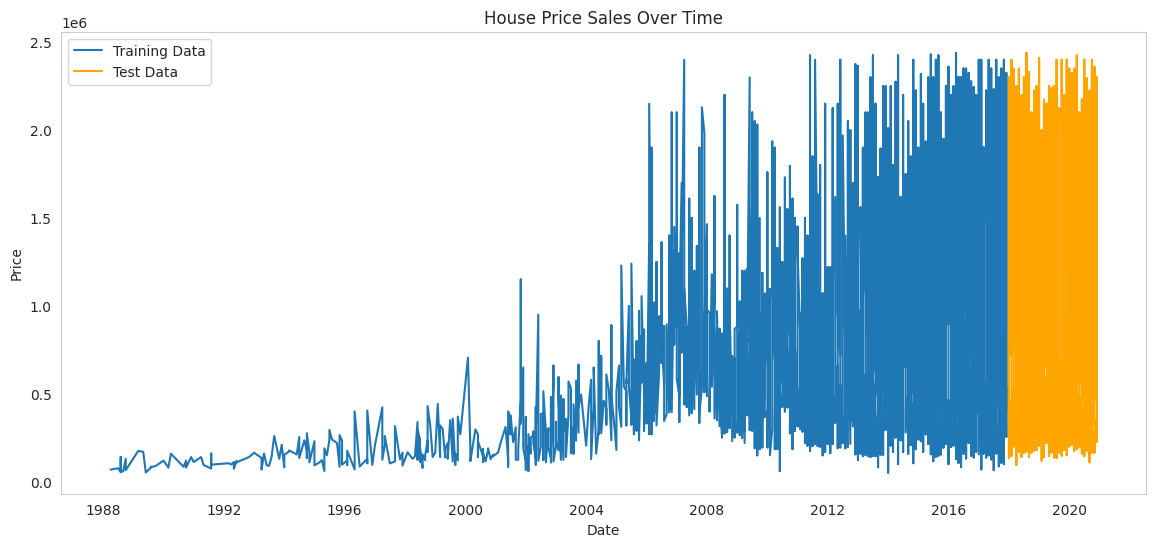

In [55]:
import matplotlib.pyplot as plt

# Example visualization
plt.figure(figsize=(14, 6))
plt.plot(train_pd['PRICE'], label="Training Data")
plt.plot(test_pd['PRICE'], label="Test Data", color='orange')
plt.title("House Price Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

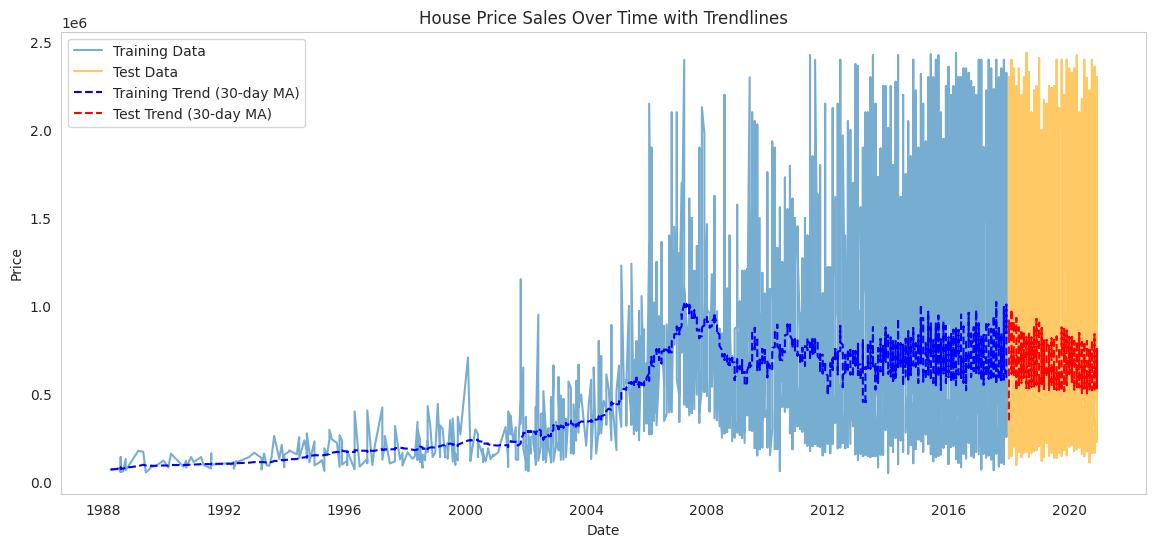

In [56]:
# Define window for moving averages
window_spec = Window.orderBy("DATE_SOLD").rowsBetween(-30, 0)  # Rolling 30-day window

# Compute Moving Averages for Trendline
train_df = train_df.withColumn("Trend_30", avg(col("PRICE")).over(window_spec))
test_df = test_df.withColumn("Trend_30", avg(col("PRICE")).over(window_spec))

# Convert to Pandas for Visualization
train_pd = train_df.select("DATE_SOLD", "PRICE", "Trend_30").toPandas()
test_pd = test_df.select("DATE_SOLD", "PRICE", "Trend_30").toPandas()

# Set Date as Index
train_pd.set_index('DATE_SOLD', inplace=True)
test_pd.set_index('DATE_SOLD', inplace=True)

# Plot Prices with Trendlines
plt.figure(figsize=(14, 6))
plt.plot(train_pd['PRICE'], label="Training Data", alpha=0.6)
plt.plot(test_pd['PRICE'], label="Test Data", color='orange', alpha=0.6)

# Add Moving Average Trendlines
plt.plot(train_pd['Trend_30'], label="Training Trend (30-day MA)", color='blue', linestyle="dashed")
plt.plot(test_pd['Trend_30'], label="Test Trend (30-day MA)", color='red', linestyle="dashed")

# Customize Plot
plt.title("House Price Sales Over Time with Trendlines")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [57]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.6 MB/s eta 0:00:00


<ipython-input-61-914c896caea0>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pd["DATE_SOLD"] = pd.to_datetime(df_pd["DATE_SOLD"])


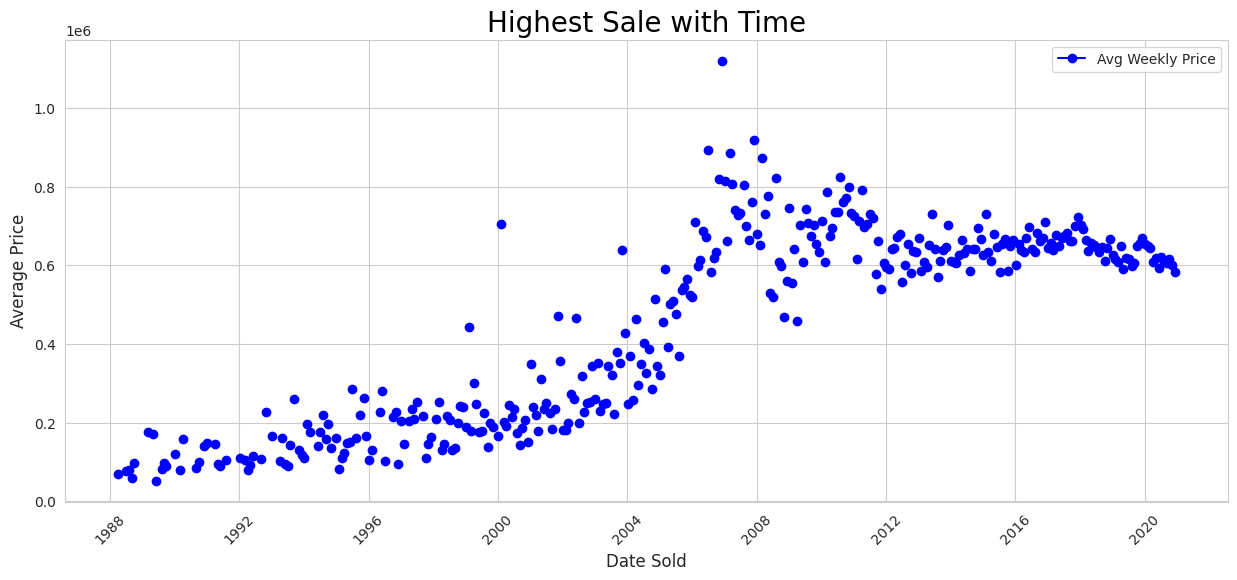

In [61]:
# Convert PySpark DataFrame to Pandas
df_pd = df.select("DATE_SOLD", "PRICE").toPandas()

# Ensure DATE_SOLD is in datetime format
df_pd["DATE_SOLD"] = pd.to_datetime(df_pd["DATE_SOLD"])

# Set DATE_SOLD as index and resample by week ('W')
df_pd.set_index("DATE_SOLD", inplace=True)
y = df_pd["PRICE"].resample("W").mean()

# Plot Time Series
plt.figure(figsize=(15, 6))
plt.plot(y, marker="o", linestyle="-", color="b", label="Avg Weekly Price")
plt.title("Highest Sale with Time", fontsize=20, color="black")
plt.xlabel("Date Sold", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

Preparing the Data for Model Fitting

# More Feature Engineering

In [62]:
df_t2.printSchema()

root
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: integer (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)
 |-- YEAR_SOLD: integer (nullable = true)
 |-- MONTH_SOLD: integer (nullable = true)
 |-- DATE_TIMESTAMP: long (nullable = true)
 |-- PROPERTY_AGE: integer (nullable = true)
 |-- AGE_CATEGORY: string (nullable = false)
 |-- LAG_1: integer (nullable = true)
 |-- LAG_3: integer (nullable = true)
 |-- MA_3: double (nullable = true)
 |-- MA_6: double (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- WEEK_OF_YEAR: integer (null

Encoding the AGE_CATEGORY for Linear and Tree based models

In [63]:
from pyspark.sql.functions import when, year, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Dynamically get the current year
current_year = 2025  # Replace with year(current_date()) if needed

# Create Age Category column
df_t2 = df_t2.withColumn(
    "BUILD_AGE_CAT",
    when((current_year - col("BUILD_YEAR")) > 50, "Old")      # Houses older than 50 years
    .when((current_year - col("BUILD_YEAR")) >= 20, "Moderate")  # Houses between 20-50 years
    .otherwise("New")  # Houses less than 20 years old
)

In [64]:
# Label Encoding for Linear Regression & GLR
df_t2 = df_t2.withColumn(
    "BUILD_AGE_LABEL",
    when(col("BUILD_AGE_CAT") == "Old", 2)
    .when(col("BUILD_AGE_CAT") == "Moderate", 1)
    .otherwise(0)
)

In [65]:
# Label Encoding for Random Forest & XGBoost

# Convert categorical labels to indices
indexer = StringIndexer(inputCol="BUILD_AGE_CAT", outputCol="BUILD_AGE_INDEX")
df_t2 = indexer.fit(df_t2).transform(df_t2)

In [66]:
# Apply One-Hot Encoding (For Linear Regression)
encoder = OneHotEncoder(inputCol="BUILD_AGE_INDEX", outputCol="AGE_VECTOR")
df_t2 = encoder.fit(df_t2).transform(df_t2)

In [67]:
# Final Data Structure
df_t2.select("BUILD_YEAR", "BUILD_AGE_CAT", "BUILD_AGE_LABEL", "AGE_VECTOR").show(5, truncate=False)

+----------+-------------+---------------+-------------+
|BUILD_YEAR|BUILD_AGE_CAT|BUILD_AGE_LABEL|AGE_VECTOR   |
+----------+-------------+---------------+-------------+
|NULL      |New          |0              |(2,[1],[1.0])|
|1980      |Moderate     |1              |(2,[0],[1.0])|
|1960      |Old          |2              |(2,[],[])    |
|1970      |Old          |2              |(2,[],[])    |
|1990      |Moderate     |1              |(2,[0],[1.0])|
+----------+-------------+---------------+-------------+
only showing top 5 rows



In [68]:
df_t2.printSchema()

root
 |-- PRICE: integer (nullable = true)
 |-- BEDROOMS: integer (nullable = true)
 |-- BATHROOMS: integer (nullable = true)
 |-- LAND_AREA: integer (nullable = true)
 |-- FLOOR_AREA: integer (nullable = true)
 |-- BUILD_YEAR: integer (nullable = true)
 |-- CBD_DIST: integer (nullable = true)
 |-- NEAREST_STN_DIST: integer (nullable = true)
 |-- DATE_SOLD: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- NEAREST_SCH_DIST: double (nullable = true)
 |-- NEAREST_SCH_RANK: integer (nullable = true)
 |-- YEAR_SOLD: integer (nullable = true)
 |-- MONTH_SOLD: integer (nullable = true)
 |-- DATE_TIMESTAMP: long (nullable = true)
 |-- PROPERTY_AGE: integer (nullable = true)
 |-- AGE_CATEGORY: string (nullable = false)
 |-- LAG_1: integer (nullable = true)
 |-- LAG_3: integer (nullable = true)
 |-- MA_3: double (nullable = true)
 |-- MA_6: double (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- WEEK_OF_YEAR: integer (null

In [69]:
df_t2 = df_t2.drop("AGE_CATEGORY", "BUILD_AGE_CAT", "DATE_SOLD")

In [70]:
df_t2 = df_t2.dropna()

# Preparing the Model

In [71]:
df_t2.columns

['PRICE',
 'BEDROOMS',
 'BATHROOMS',
 'LAND_AREA',
 'FLOOR_AREA',
 'BUILD_YEAR',
 'CBD_DIST',
 'NEAREST_STN_DIST',
 'LATITUDE',
 'LONGITUDE',
 'NEAREST_SCH_DIST',
 'NEAREST_SCH_RANK',
 'YEAR_SOLD',
 'MONTH_SOLD',
 'DATE_TIMESTAMP',
 'PROPERTY_AGE',
 'LAG_1',
 'LAG_3',
 'MA_3',
 'MA_6',
 'QUARTER',
 'WEEK_OF_YEAR',
 'DAY_OF_WEEK',
 'BUILD_AGE_LABEL',
 'BUILD_AGE_INDEX',
 'AGE_VECTOR']

In [76]:
tree_features = ['BEDROOMS',
 'BATHROOMS',
 'LAND_AREA',
 'FLOOR_AREA',
 'BUILD_YEAR',
 'CBD_DIST',
 'NEAREST_STN_DIST',
 'LATITUDE',
 'LONGITUDE',
 'NEAREST_SCH_DIST',
 'NEAREST_SCH_RANK',
 'DATE_TIMESTAMP',
 'PROPERTY_AGE',
 'LAG_1',
 'LAG_3',
 'MA_3',
 'MA_6',
 'QUARTER',
 'WEEK_OF_YEAR',
 'DAY_OF_WEEK',
 'BUILD_AGE_LABEL',
 'BUILD_AGE_INDEX']
linear_features = ['BEDROOMS',
 'BATHROOMS',
 'LAND_AREA',
 'FLOOR_AREA',
 'BUILD_YEAR',
 'CBD_DIST',
 'NEAREST_STN_DIST',
 'LATITUDE',
 'LONGITUDE',
 'NEAREST_SCH_DIST',
 'NEAREST_SCH_RANK',
 'DATE_TIMESTAMP',
 'PROPERTY_AGE',
 'LAG_1',
 'LAG_3',
 'MA_3',
 'MA_6',
 'QUARTER',
 'WEEK_OF_YEAR',
 'DAY_OF_WEEK',
 'BUILD_AGE_INDEX',
 'AGE_VECTOR']



In [77]:
# Assemble Features
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler_tree = VectorAssembler(inputCols=tree_features, outputCol="tree_features")
df_tr = assembler_tree.transform(df_t2)
assembler_linear = VectorAssembler(inputCols=linear_features, outputCol="linear_features")
df_lr = assembler_linear.transform(df_t2)

target_col = "PRICE"

In [78]:
# Keep only the "features" vector and the target variable
df_final_tr = df_tr.select("tree_features", target_col)
df_final_tr.show()

+--------------------+------+
|       tree_features| PRICE|
+--------------------+------+
|[3.0,1.0,2173.0,8...| 62000|
|[5.0,2.0,62982.0,...|140000|
|[4.0,2.0,90527.0,...| 54500|
|[4.0,2.0,20339.0,...| 60000|
|[4.0,1.0,3953.0,2...|130000|
|[4.0,1.0,21179.0,...| 65500|
|[4.0,2.0,16586.0,...|175000|
|[3.0,1.0,92333.0,...|170000|
|[3.0,2.0,20058.0,...| 52000|
|[4.0,1.0,20728.0,...| 80000|
|[4.0,3.0,29916.0,...| 85000|
|[4.0,1.0,20023.0,...| 82000|
|[4.0,3.0,28225.0,...| 90000|
|[5.0,2.0,8776.0,1...|120000|
|[5.0,2.0,4859.0,1...| 80000|
|[3.0,2.0,20389.0,...| 80000|
|[6.0,3.0,10000.0,...|140000|
|[4.0,1.0,1011.0,1...|112000|
|[5.0,2.0,53758.0,...|140000|
|[3.0,2.0,5963.0,2...|140000|
+--------------------+------+
only showing top 20 rows



In [79]:
# Keep only the "features" vector and the target variable
df_final_lr = df_lr.select("linear_features", target_col)
df_final_lr.show()

+--------------------+------+
|     linear_features| PRICE|
+--------------------+------+
|[3.0,1.0,2173.0,8...| 62000|
|[5.0,2.0,62982.0,...|140000|
|[4.0,2.0,90527.0,...| 54500|
|[4.0,2.0,20339.0,...| 60000|
|[4.0,1.0,3953.0,2...|130000|
|[4.0,1.0,21179.0,...| 65500|
|[4.0,2.0,16586.0,...|175000|
|[3.0,1.0,92333.0,...|170000|
|[3.0,2.0,20058.0,...| 52000|
|[4.0,1.0,20728.0,...| 80000|
|[4.0,3.0,29916.0,...| 85000|
|[4.0,1.0,20023.0,...| 82000|
|[4.0,3.0,28225.0,...| 90000|
|[5.0,2.0,8776.0,1...|120000|
|[5.0,2.0,4859.0,1...| 80000|
|[3.0,2.0,20389.0,...| 80000|
|[6.0,3.0,10000.0,...|140000|
|[4.0,1.0,1011.0,1...|112000|
|[5.0,2.0,53758.0,...|140000|
|[3.0,2.0,5963.0,2...|140000|
+--------------------+------+
only showing top 20 rows



In [80]:
#Normalizing the features
# Define StandardScaler
lr_scaler = StandardScaler(inputCol="linear_features", outputCol="scaledFeaturesLR", withStd=True, withMean=False)
tree_scaler = StandardScaler(inputCol="tree_features", outputCol="scaledFeaturesTR", withStd=True, withMean=False)


In [81]:
# Fit the scaler to the data
lr_scaler_model = lr_scaler.fit(df_final_lr)
tree_scaler_model = tree_scaler.fit(df_final_tr)

In [82]:
# Transform the data using the fitted scaler
df_linear = lr_scaler_model.transform(df_final_lr)
df_tree = tree_scaler_model.transform(df_final_tr)

In [83]:
# Show transformed data
df_linear.show()
df_tree.show()

+--------------------+------+--------------------+
|     linear_features| PRICE|    scaledFeaturesLR|
+--------------------+------+--------------------+
|[3.0,1.0,2173.0,8...| 62000|[3.94827525680334...|
|[5.0,2.0,62982.0,...|140000|[6.58045876133891...|
|[4.0,2.0,90527.0,...| 54500|[5.26436700907112...|
|[4.0,2.0,20339.0,...| 60000|[5.26436700907112...|
|[4.0,1.0,3953.0,2...|130000|[5.26436700907112...|
|[4.0,1.0,21179.0,...| 65500|[5.26436700907112...|
|[4.0,2.0,16586.0,...|175000|[5.26436700907112...|
|[3.0,1.0,92333.0,...|170000|[3.94827525680334...|
|[3.0,2.0,20058.0,...| 52000|[3.94827525680334...|
|[4.0,1.0,20728.0,...| 80000|[5.26436700907112...|
|[4.0,3.0,29916.0,...| 85000|[5.26436700907112...|
|[4.0,1.0,20023.0,...| 82000|[5.26436700907112...|
|[4.0,3.0,28225.0,...| 90000|[5.26436700907112...|
|[5.0,2.0,8776.0,1...|120000|[6.58045876133891...|
|[5.0,2.0,4859.0,1...| 80000|[6.58045876133891...|
|[3.0,2.0,20389.0,...| 80000|[3.94827525680334...|
|[6.0,3.0,10000.0,...|140000|[7

Train Test split

In [84]:
# Define the train-test split ratio (80% train, 20% test)
train_ratio = 0.8
test_ratio = 0.2
seed = 42  # Set seed for reproducibility

In [85]:
# Split Linear Model Dataset
train_linear, test_linear = df_linear.randomSplit([train_ratio, test_ratio], seed=seed)

# Split Tree Model Dataset
train_tree, test_tree = df_tree.randomSplit([train_ratio, test_ratio], seed=seed)

In [86]:
# Print the number of rows in each set
print(f"Linear Model: Training Rows = {train_linear.count()}, Test Rows = {test_linear.count()}")
print(f"Tree Model: Training Rows = {train_tree.count()}, Test Rows = {test_tree.count()}")

Linear Model: Training Rows = 16601, Test Rows = 4089
Tree Model: Training Rows = 16601, Test Rows = 4089


In [87]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor

# Define the four models with their respective feature columns
models = {
    "Linear Regression": LinearRegression(featuresCol="scaledFeaturesLR", labelCol="PRICE"),
    "Generalized Regression": GeneralizedLinearRegression(featuresCol="scaledFeaturesLR", labelCol="PRICE", family="gaussian"),
    "Random Forest": RandomForestRegressor(featuresCol="scaledFeaturesTR", labelCol="PRICE", numTrees=100),
    "Gradient Boosting": GBTRegressor(featuresCol="scaledFeaturesTR", labelCol="PRICE"),
    "Decision Tree": DecisionTreeRegressor(featuresCol="scaledFeaturesTR", labelCol="PRICE")
}

# Dictionary to store trained models
trained_models = {}



In [88]:
# Mapping models to their respective training datasets
dataset_map = {
    "Linear Regression": train_linear,  # Use train_linear for Linear Regression
    "Generalized Regression": train_linear,  # Use train_linear for GLR
    "Random Forest": train_tree,        # Use train_tree for Tree-based models
    "Gradient Boosting": train_tree,
    "Decision Tree": train_tree
}


In [89]:
# Iterate through each model and fit it to the respective dataset
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Get the appropriate dataset
    train_data = dataset_map[model_name]

    # Train the model
    trained_model = model.fit(train_data)

    # Store the trained model
    trained_models[model_name] = trained_model

print("Training complete!")

Training Linear Regression...
Training Generalized Regression...
Training Random Forest...
Training Gradient Boosting...
Training Decision Tree...
Training complete!


# Making the Predictions

In [90]:
# Dictionary to store predictions
predictions = {}
y_pred = {}  # Dictionary to store only the predicted values separately

# Generate predictions for each trained model
for model_name, trained_model in trained_models.items():
    print(f"Generating predictions for {model_name}...")

    # Select the appropriate test dataset
    test_data = dataset_map[model_name]  # Uses the dataset mapping from training

    # Make predictions
    predictions[model_name] = trained_model.transform(test_data)

    # Store only the predicted values separately
    y_pred[model_name] = predictions[model_name].select("prediction")

print("Predictions complete!")

Generating predictions for Linear Regression...
Generating predictions for Generalized Regression...
Generating predictions for Random Forest...
Generating predictions for Gradient Boosting...
Generating predictions for Decision Tree...
Predictions complete!


# Evaluation

In [91]:
# Define evaluators
rmse_evaluator = RegressionEvaluator(labelCol="PRICE", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="PRICE", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="PRICE", predictionCol="prediction", metricName="r2")

# Store evaluation results
evaluation_results = {}

# Evaluate each model
for model_name, preds in predictions.items():
    rmse = rmse_evaluator.evaluate(preds)
    mae = mae_evaluator.evaluate(preds)
    r2 = r2_evaluator.evaluate(preds)

    evaluation_results[model_name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"{model_name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")


Linear Regression: RMSE=198145.073, MAE=142448.913, R²=0.740
Generalized Regression: RMSE=198145.073, MAE=142448.913, R²=0.740
Random Forest: RMSE=198153.211, MAE=141612.541, R²=0.740
Gradient Boosting: RMSE=157988.280, MAE=110842.520, R²=0.835
Decision Tree: RMSE=217199.025, MAE=153407.353, R²=0.688


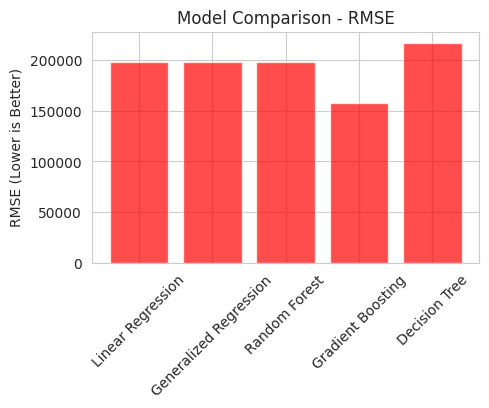

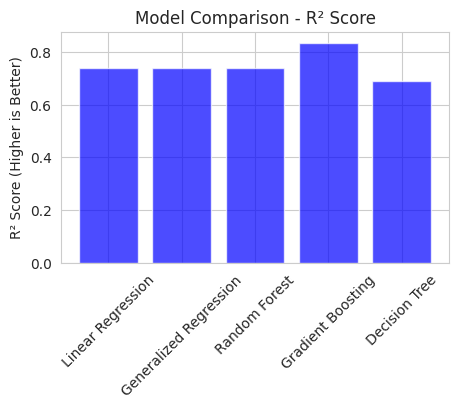

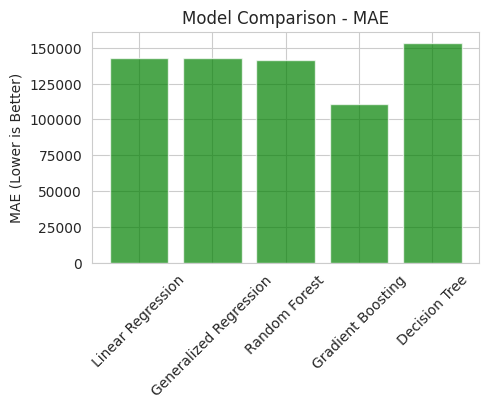

In [94]:
# Extract evaluation results
models = list(evaluation_results.keys())
rmse_scores = [evaluation_results[m]["RMSE"] for m in models]
r2_scores = [evaluation_results[m]["R2"] for m in models]

# Set positions for bars
x = np.arange(len(models))

# Plot RMSE
plt.figure(figsize=(5, 3))
plt.bar(x, rmse_scores, color='red', alpha=0.7)
plt.xticks(x, models, rotation=45)
plt.ylabel("RMSE (Lower is Better)")
plt.title("Model Comparison - RMSE")
plt.show()

# Plot R² Score
plt.figure(figsize=(5, 3))
plt.bar(x, r2_scores, color='blue', alpha=0.7)
plt.xticks(x, models, rotation=45)
plt.ylabel("R² Score (Higher is Better)")
plt.title("Model Comparison - R² Score")
plt.show()

# Plot MAE
plt.figure(figsize=(5, 3))
mae_scores = [evaluation_results[m]["MAE"] for m in models]
plt.bar(x, mae_scores, color='green', alpha=0.7)
plt.xticks(x, models, rotation=45)
plt.ylabel("MAE (Lower is Better)")
plt.title("Model Comparison - MAE")
plt.show()

In [95]:
# Select model with highest R²
best_model_name = max(evaluation_results, key=lambda m: evaluation_results[m]["R2"])
print(f"Best model is: {best_model_name}")

Best model is: Gradient Boosting


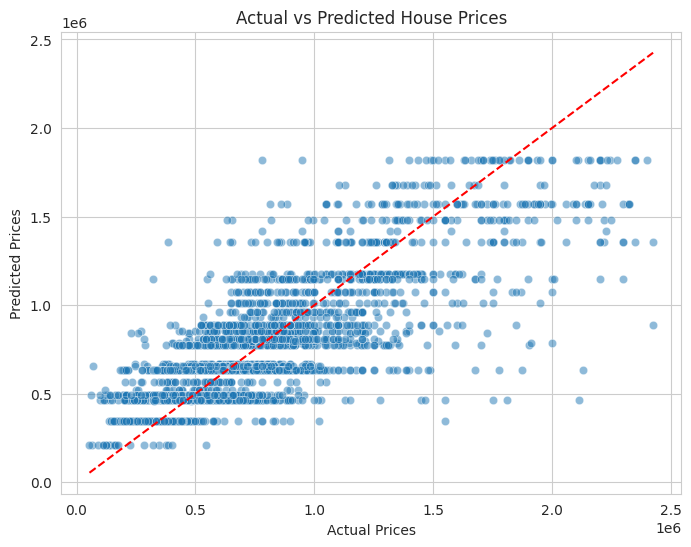

In [119]:
# Select a model (example: Random Forest)
selected_model = trained_models["Decision Tree"]
predictions = selected_model.transform(test_tree).select("PRICE", "prediction").toPandas()

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions["PRICE"], y=predictions["prediction"], alpha=0.5)
plt.plot([predictions["PRICE"].min(), predictions["PRICE"].max()],
         [predictions["PRICE"].min(), predictions["PRICE"].max()],
         color="red", linestyle="--")  # Ideal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()

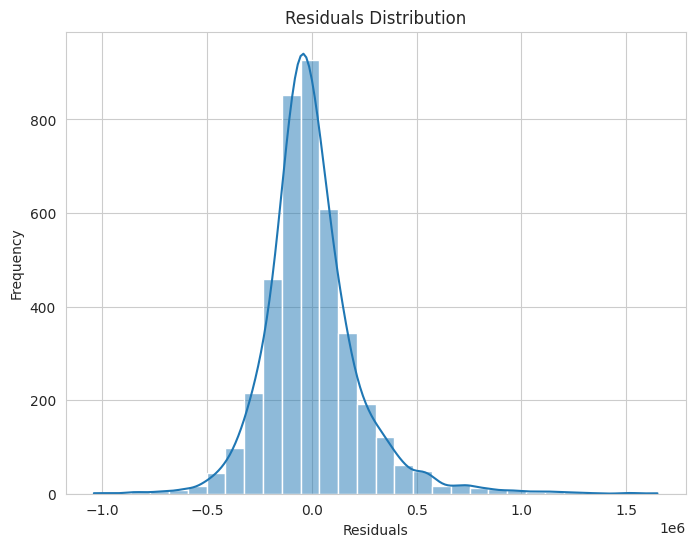

In [120]:
# Calculate residuals
predictions["Residuals"] = predictions["PRICE"] - predictions["prediction"]

# Residuals plot
plt.figure(figsize=(8, 6))
sns.histplot(predictions["Residuals"], bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

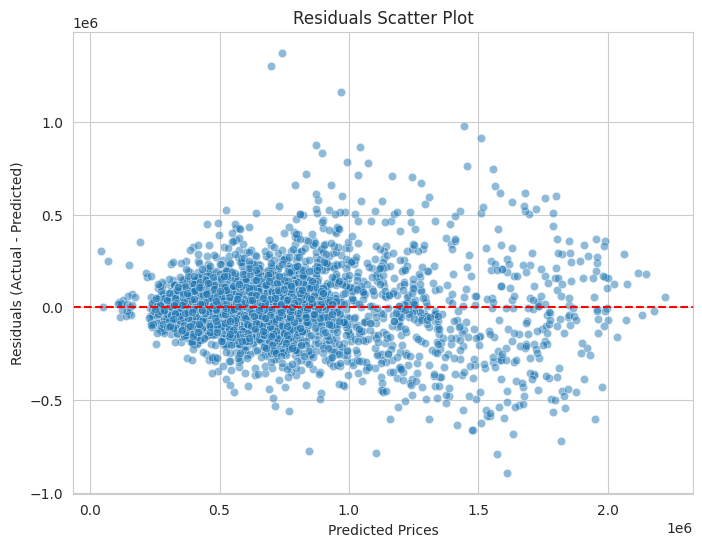

In [121]:
# Select a trained model (Example: Random Forest)
selected_model = trained_models["Gradient Boosting"]

# Make predictions
predictions_df = selected_model.transform(test_tree).select("PRICE", "prediction").toPandas()

# Compute Residuals (Error = Actual - Predicted)
predictions_df["Residuals"] = predictions_df["PRICE"] - predictions_df["prediction"]

# Scatter Plot: Residuals vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_df["prediction"], y=predictions_df["Residuals"], alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")  # Reference line at 0
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Scatter Plot")
plt.show()

Extract a specific Model

In [99]:

# Choose the model name (update as needed)
selected_model = "Gradient Boosting"  # Change this to the desired model name

# Extract the Spark DataFrame containing predictions for the selected model
y_pred_df = y_pred[selected_model]  # Get predictions for the chosen model

# Convert Spark DataFrame predictions to a NumPy array
y_pred_np = np.array(y_pred_df.select("prediction").rdd.flatMap(lambda x: x).collect())

# Ensure it has the correct shape
y_pred_np = y_pred_np.reshape(-1, 1)  # Reshape to 2D for OLS

print(y_pred_np[:5])  # Display first 5 predictions

[[409299.76204857]
 [579510.43776715]
 [570231.88839046]
 [893071.07690821]
 [958649.63181239]]


In [100]:
# Select the model you want to analyze
selected_model = "Gradient Boosting"  # Change to desired model name

# Extract y_pred DataFrame from dictionary
y_pred_df = y_pred[selected_model]  # Get the Spark DataFrame for predictions

# Convert Spark DataFrame column "prediction" to a NumPy array
y_pred_np = np.array(y_pred_df.select("prediction").rdd.flatMap(lambda x: x).collect())

print(y_pred_np[:5])  # Preview first few values

[409299.76204857 579510.43776715 570231.88839046 893071.07690821
 958649.63181239]


In [101]:
# Extract features from the same test set used for predictions
X_np = np.array(test_data.select("scaledFeaturesTR").rdd.map(lambda x: x[0]).collect())

# Ensure y_pred is extracted from the same dataset
y_pred_np = np.array(y_pred_df.select("prediction").rdd.flatMap(lambda x: x).collect())

print("Fixed Shape of X_np:", X_np.shape)
print("Fixed Shape of y_pred_np:", y_pred_np.shape)

Fixed Shape of X_np: (16601, 22)
Fixed Shape of y_pred_np: (16601,)


In [102]:
import statsmodels.api as sm  # Import statsmodels

X_np = sm.add_constant(X_np)  # Add intercept term to feature matrix
model = sm.OLS(y_pred_np, X_np).fit()
print(model.summary())  # Display OLS regression results

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     3276.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:59:02   Log-Likelihood:            -2.2238e+05
No. Observations:               16601   AIC:                         4.448e+05
Df Residuals:                   16579   BIC:                         4.450e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.726e+04    452.609     38.125      0.0

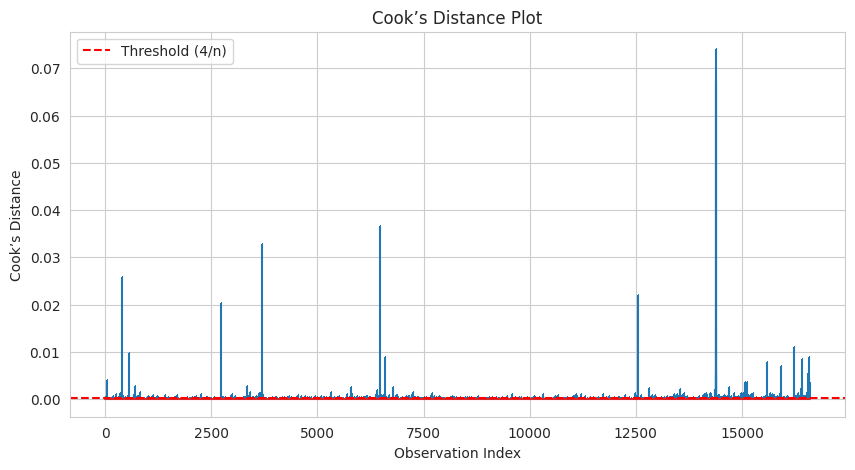

High Influence Points (indices): [   43   401   553  2738  3696  6485  6582 12553 14395 14396 14397 14398
 14399 14400 15073 15111 15601 15919 16220 16406 16562 16585 16587 16588
 16600]


In [103]:


# Compute Cook’s Distance
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance  # Extract Cook's distances

# Plot Cook’s Distance
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(4 / len(X_np), color="r", linestyle="--", label="Threshold (4/n)")
plt.title("Cook’s Distance Plot")
plt.xlabel("Observation Index")
plt.ylabel("Cook’s Distance")
plt.legend()
plt.show()

# Identify high influence points
threshold = 50 / len(X_np)
high_influence_points = np.where(cooks_d > threshold)[0]
print(f"High Influence Points (indices): {high_influence_points}")

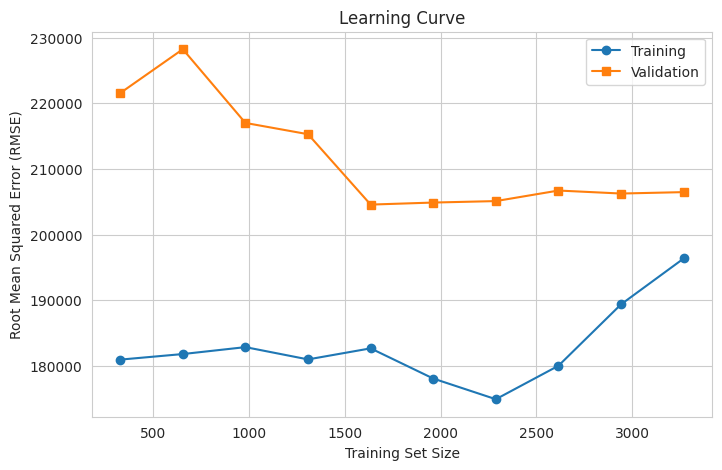

In [108]:

from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

# Convert the PySpark DataFrame to a pandas DataFrame
test_dataset_pd = test_tree.toPandas()

# Extract features and target as NumPy arrays
X = np.array(test_dataset_pd['scaledFeaturesTR'].tolist())
y = test_dataset_pd['PRICE'].values  # Assuming 'PRICE' is your target column

# Define model with pipeline
model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))


# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10))

# Convert negative MSE to positive RMSE
train_scores = np.sqrt(-train_scores)
val_scores = np.sqrt(-val_scores)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training", marker="o")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation", marker="s")
plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Learning Curve")
plt.legend()
plt.show()